## References
* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture13-CNNs.pdf
* CNN Architecture - http://www.aclweb.org/anthology/D14-1181
* Dataset - http://cogcomp.org/Data/QA/QC/
* RNN Intuition - https://arxiv.org/abs/1801.06146 (using fastai)

In [0]:
!pip install -q fastai

In [0]:
!curl -o - https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz | gunzip > ./GoogleNews-vectors-negative300.bin

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1570M  100 1570M    0     0  29.4M      0  0:00:53  0:00:53 --:--:-- 38.1M


In [0]:
!wget http://cogcomp.org/Data/QA/QC/train_5500.label

--2019-01-01 12:16:17--  http://cogcomp.org/Data/QA/QC/train_5500.label
Resolving cogcomp.org (cogcomp.org)... 192.17.58.140
Connecting to cogcomp.org (cogcomp.org)|192.17.58.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335858 (328K) [text/plain]
Saving to: ‘train_5500.label’

train_5500.label    100%[===================>] 327.99K  --.-KB/s    in 0.06s   

2019-01-01 12:16:18 (5.82 MB/s) - ‘train_5500.label’ saved [335858/335858]



In [0]:
from fastai.text import *
import gensim

In [0]:
PATH = Path('data/trec')
PATH.mkdir(parents=True, exist_ok=True)
WORD_VECTORS = PATH/'GoogleNews-vectors-negative300.bin'

In [3]:
!mv 'GoogleNews-vectors-negative300.bin' {PATH}
!mv 'train_5500.label' {PATH}
PATH.ls()

mv: cannot stat 'GoogleNews-vectors-negative300.bin': No such file or directory
mv: cannot stat 'train_5500.label': No such file or directory


[PosixPath('data/trec/GoogleNews-vectors-negative300.bin'),
 PosixPath('data/trec/train.csv'),
 PosixPath('data/trec/train_5500.label'),
 PosixPath('data/trec/models'),
 PosixPath('data/trec/data_cl'),
 PosixPath('data/trec/data_lm')]

## Data

In [4]:
qa_data = open(PATH/'train_5500.label', 'r', encoding='latin-1').readlines()
qa_data = [l.split(':', 1) for l in qa_data]

qa_data = pd.DataFrame(qa_data)
qa_data.columns = ['label', 'text']
qa_data.to_csv(PATH/'train.csv', header=True, index=False)

qa_data = pd.read_csv(PATH/'train.csv')
print(qa_data.shape)
qa_data.head()

(5452, 2)


,label,text
0,DESC,manner How did serfdom develop in and then lea...
1,ENTY,cremat What films featured the character Popey...
2,DESC,manner How can I find a list of celebrities ' ...
3,ENTY,animal What fowl grabs the spotlight after the...
4,ABBR,exp What is the full form of .com ?\n


In [0]:
data_lm = (TextList.from_csv(PATH, 'train.csv', cols='text')
          .random_split_by_pct(0.1)
          .label_for_lm()
          .databunch(bs=32))

data_cl = (TextList.from_csv(PATH, 'train.csv', cols='text', vocab=data_lm.vocab)
          .random_split_by_pct(0.1)
          .label_from_df(cols='label')
          .databunch(bs=32))

In [0]:
data_lm.save('data_lm')
data_cl.save('data_cl')

In [0]:
data_lm = TextLMDataBunch.load(PATH, 'data_lm', bs=32)
data_cl = TextClasDataBunch.load(PATH, 'data_cl', bs=32)

In [8]:
data_lm.show_batch()

idx,text
0,xxbos gr xxmaj who is the leading xxunk of xxmaj xxunk xxmaj union xxmaj company ? \n xxbos other xxmaj what famed xxmaj london criminal court was once a xxunk castle ? \n xxbos ind xxmaj what composer was awarded the xxmaj medal of xxmaj xxunk by xxmaj franklin xxup d. xxmaj roosevelt ? \n xxbos animal xxmaj what xxmaj triple xxmaj crown - winning horse took the 1973 xxmaj
1,"is not gold '' ? \n xxbos other xxmaj what xxunk do you use to xxunk ? \n xxbos count xxmaj how many words are there in the xxmaj spanish language ? \n xxbos ind xxmaj what poet wrote : `` ... i have xxunk to keep , and miles to go before i sleep '' ? \n xxbos dismed xxmaj what chemicals are used in xxunk xxunk ? \n"
2,xxunk xxmaj xxunk ? \n xxbos def xxmaj what is the classic definition of xxunk hero ? \n xxbos other xxmaj where can i find book xxunk of `` xxmaj xxunk xxmaj xxunk '' ? \n xxbos ind xxmaj what xxunk - xxunk comedian xxunk : `` xxmaj you 're only as old as the woman you xxunk '' ? \n xxbos ind xxmaj who xxunk the weather on the
3,"invented the paper xxunk ? \n xxbos desc xxmaj what 's new in the xxunk world in 1999 ? \n xxbos cremat xxmaj what movie has made the most money ? \n xxbos cremat xxmaj what xxunk silent film received an international xxunk in 1981 ? \n xxbos gr xxmaj who xxunk telephone service in xxmaj orange xxmaj county , xxmaj california ? \n xxbos date xxmaj the film ``"
4,did xxmaj joseph xxmaj xxunk name for its xxunk to xxunk xxunk xxunk ? \n xxbos def xxmaj define the xxmaj xxunk xxmaj club ? \n xxbos ind xxmaj what xxmaj french leader sold xxmaj xxunk to the xxmaj united xxmaj states ? \n xxbos def xxmaj what are xxunk ? \n xxbos dist xxmaj how tall is xxmaj prince xxmaj charles ? \n xxbos desc xxmaj what is the


In [9]:
data_cl.show_batch()

text,target
"xxbos ind xxmaj who was named xxmaj xxunk of the xxmaj ocean xxmaj seas and xxmaj xxunk and xxmaj governor xxmaj general of all the islands he xxunk discover , and also xxunk xxunk ? ? of all xxunk of his xxunk . \n",HUM
xxbos ind xxmaj who was the author of the book about computer xxunk called `` xxmaj the xxmaj xxunk 's xxmaj egg : xxmaj xxunk a xxmaj spy xxmaj through the xxmaj xxunk of xxmaj computer xxmaj xxunk '' ? \n,HUM
"xxbos dismed xxmaj what is the name of the xxunk xxunk disease with xxunk such as : xxunk xxunk , xxunk , xxunk , and xxunk xxunk , xxunk , xxunk , etc . ? \n",ENTY
"xxbos ind xxmaj who was the captain of the xxunk , xxmaj xxunk xxmaj valdez , xxunk in the oil spill in xxmaj prince xxmaj william xxmaj sound , xxmaj alaska , 1989 ? \n",HUM
xxbos date xxmaj what year is xxunk on the xxmaj gold xxmaj medal of xxmaj xxunk from the xxmaj paris xxmaj xxunk xxunk on a can of xxmaj xxunk 's xxunk soup ? \n,NUM


## Pretrained embedding vectors

In [0]:
word_embed_model = gensim.models.KeyedVectors.load_word2vec_format(WORD_VECTORS, binary=True)

In [0]:
embeddings = []
for w in data_cl.vocab.itos:
    try:
        embeddings.append(word_embed_model[w])
    except KeyError:
        embeddings.append(np.random.randn(300))

embeddings = np.vstack(embeddings)

## With CNN-model

In [0]:
class CNNClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_size, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim, output_size)
    
    
    def init_weights(self, embeddings, is_static=False):
        self.embedding.weight = nn.Parameter(torch.from_numpy(embeddings).float())
        if is_static:
            self.embedding.weight.requires_grad = False


    def forward(self, inputs, is_training=False):
        inputs = self.embedding(inputs).unsqueeze(1)
        inputs = [F.relu(conv(inputs)).squeeze(3) for conv in self.convs]
        inputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in inputs]

        concated = torch.cat(inputs, 1)

        if is_training:
            concated = self.dropout(concated)
        out = self.fc(concated) 
        return out

### With no embeddings

In [0]:
cnn_model = CNNClassifier(len(data_cl.vocab.itos), 300, data_cl.c)

In [0]:
learn = Learner(data_cl, cnn_model, loss_func = nn.CrossEntropyLoss(), metrics=[accuracy])

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


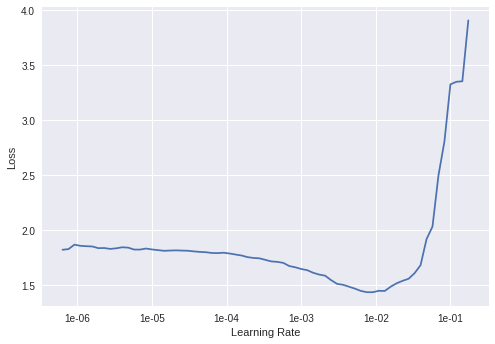

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,0.107486,0.084069,0.968807


In [0]:
learn.save('cnn-n-stage-1')

In [0]:
learn.load('cnn-n-stage-1')

### With word embeddings

In [0]:
cnn_model = CNNClassifier(len(data_cl.vocab.itos), 300, data_cl.c)
cnn_model.init_weights(embeddings)

In [0]:
learn = Learner(data_cl, cnn_model, loss_func = nn.CrossEntropyLoss(), metrics=[accuracy])

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


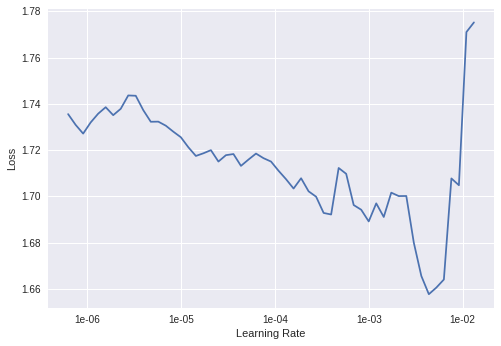

In [0]:
learn.recorder.plot(skip_end=20)

In [0]:
learn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,accuracy
1,0.169433,0.106925,0.957798
2,0.043946,0.070060,0.968807


In [0]:
learn.save('cnn-stage-1')

In [0]:
learn.load('cnn-stage-1')

## RNN Classifier with no language modelling

### With no pretrained embeddings

In [0]:
learn = text_classifier_learner(data_cl, emb_sz=300)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


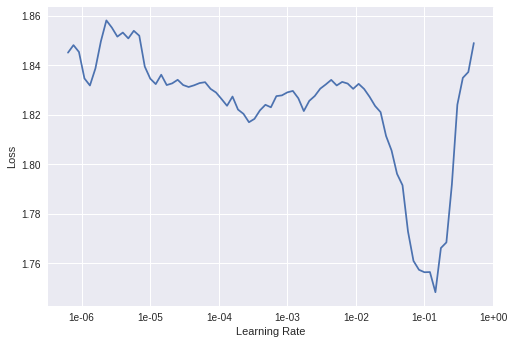

In [0]:
learn.recorder.plot(skip_end=10)

In [0]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.508991,0.582374,0.777982
2,0.287075,0.139808,0.946789
3,0.271868,0.123688,0.950459
4,0.229720,0.123420,0.950459


In [0]:
learn.save('rnn-n-stage-1')

In [0]:
learn.load('rnn-n-stage-1')

### With pretrained embeddings

In [132]:
learn = text_classifier_learner(data_cl, emb_sz=300)
learn.model.state_dict()['0.encoder.weight'].data.copy_(torch.tensor(embeddings))
learn.model.state_dict()['0.encoder_dp.emb.weight'].data.copy_(torch.tensor(embeddings))

tensor([[ 0.2575,  2.2415,  0.6293,  ...,  1.6005,  0.1004,  0.5857],
        [ 0.4745,  0.9374, -1.5300,  ...,  0.1811, -1.4925, -0.5763],
        [-0.1933,  0.2445, -0.5995,  ...,  1.9192, -0.9419,  0.9780],
        ...,
        [-0.0459, -0.2354, -0.1475,  ...,  0.0496, -0.0025,  0.1367],
        [ 1.4796, -1.2730, -1.0365,  ..., -1.6728, -1.3361, -0.1357],
        [-0.0098, -0.0718,  0.0069,  ...,  0.0439, -0.0850,  0.0287]],
       device='cuda:0')

In [0]:
learn.freeze_to(1)

In [134]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


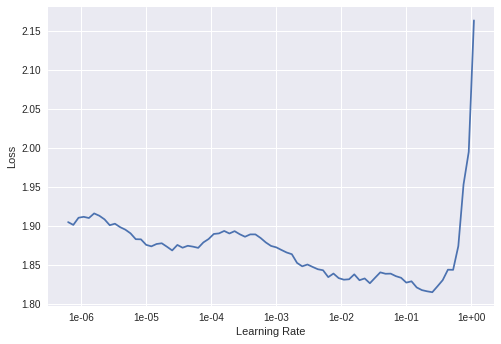

In [135]:
learn.recorder.plot(skip_end=7)

In [136]:
learn.fit_one_cycle(7, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy
1,1.545982,1.327407,0.491743
2,0.740183,0.488952,0.757798
3,0.384436,0.294283,0.908257
4,0.305681,0.123572,0.944954
5,0.217340,0.134811,0.952294
6,0.197905,0.105394,0.952294
7,0.222938,0.089613,0.961468


In [0]:
learn.unfreeze()

In [141]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


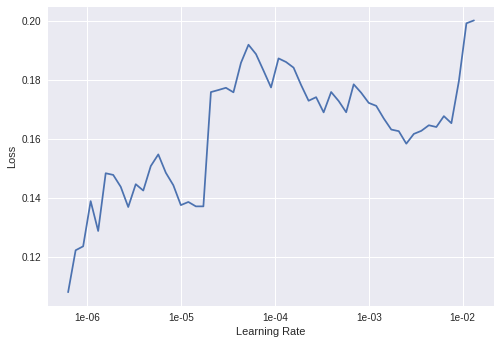

In [142]:
learn.recorder.plot()

In [143]:
learn.fit_one_cycle(5, slice(8e-4/(2.6**4), 8e-4))

epoch,train_loss,valid_loss,accuracy
1,0.164782,0.085559,0.965138
2,0.178451,0.089455,0.959633
3,0.176252,0.082654,0.963303
4,0.182119,0.090500,0.959633
5,0.159503,0.085587,0.963303


In [0]:
learn.save('rnn-stage-1')

In [0]:
learn.load('rnn-stage-1')

## Classification with language modelling

### No pretrained model and no pretrained word embeddings

In [0]:
learn = language_model_learner(data_lm, emb_sz=300, pretrained_model=None)

In [174]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


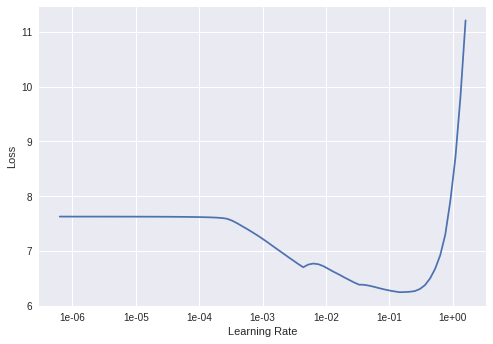

In [175]:
learn.recorder.plot()

In [176]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,5.442820,4.479351,0.145689
2,4.904764,4.445003,0.145411
3,4.744240,4.439466,0.145472
4,4.665836,4.433586,0.145358
5,4.624978,4.413255,0.147557


In [0]:
learn.save_encoder('fine-tuned-nn')

In [0]:
learn = text_classifier_learner(data_cl, emb_sz=300)
learn.load_encoder('fine-tuned-nn')

In [181]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


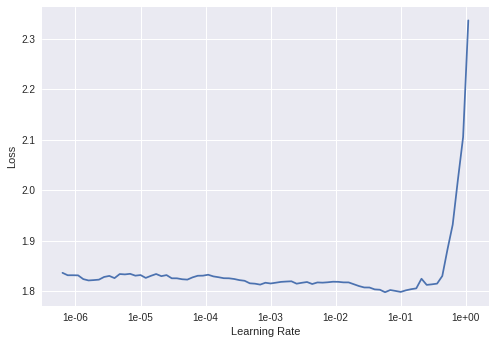

In [182]:
learn.recorder.plot()

In [183]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,1.675661,1.691837,0.205505
2,1.655682,1.672457,0.185321
3,1.653938,1.670683,0.267890
4,1.639605,1.688281,0.238532
5,1.647198,1.669646,0.242202


In [0]:
learn.save('rnn-nn-stage-1')

In [0]:
learn.load('rnn-nn-stage-1')

In [0]:
learn.freeze_to(-2)

In [187]:
learn.fit_one_cycle(5, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy
1,1.642733,1.669813,0.238532
2,1.651794,1.654659,0.242202
3,1.640221,1.658934,0.238532
4,1.651749,1.657272,0.238532
5,1.639966,1.654841,0.238532


In [0]:
learn.save('rnn-nn-stage-2')

In [0]:
learn.load('rnn-nn-stage-2')

In [0]:
learn.freeze_to(-3)

In [190]:
learn.fit_one_cycle(5, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy
1,1.643287,1.661342,0.267890
2,1.655087,1.658574,0.267890
3,1.662745,1.660244,0.216514
4,1.665598,1.656488,0.267890
5,1.639421,1.655155,0.267890


In [0]:
learn.save('rnn-nn-stage-3')

In [0]:
learn.load('rnn-nn-stage-3')

In [0]:
learn.unfreeze()

In [193]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


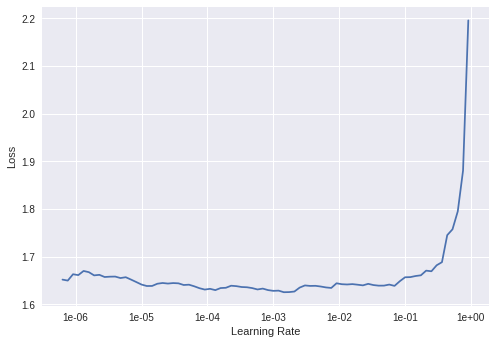

In [194]:
learn.recorder.plot()

In [195]:
learn.fit_one_cycle(7, slice(1e-4/(2.6**4), 1e-4))

epoch,train_loss,valid_loss,accuracy
1,1.662736,1.655558,0.267890
2,1.649443,1.656217,0.262385
3,1.637715,1.656054,0.264220
4,1.632960,1.653874,0.264220
5,1.641408,1.654351,0.262385
6,1.649301,1.655796,0.262385
7,1.652697,1.655532,0.262385


In [0]:
learn.save('rnn-nn-stage-4')

In [0]:
learn.load('rnn-nn-stage-4')

### No pretrained model but with pretrained word embeddings

In [0]:
learn = language_model_learner(data_lm, emb_sz=300, pretrained_model=None)
learn.model.state_dict()['0.encoder.weight'].data.copy_(torch.tensor(embeddings))
learn.model.state_dict()['0.encoder_dp.emb.weight'].data.copy_(torch.tensor(embeddings))
learn.freeze_to(1)

In [115]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


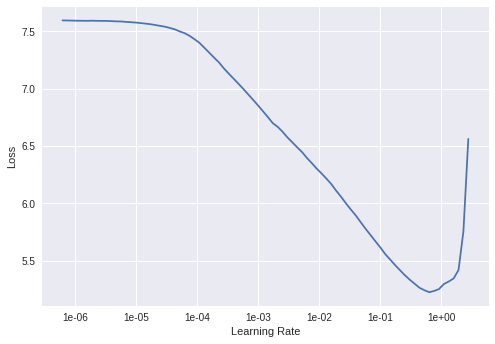

In [116]:
learn.recorder.plot()

In [117]:
learn.fit_one_cycle(5, 8e-2)

epoch,train_loss,valid_loss,accuracy
1,5.121111,3.323015,0.413564
2,3.912338,2.977148,0.454908
3,3.398068,2.777486,0.473237
4,3.065539,2.644190,0.496083
5,2.824365,2.595185,0.497530


In [0]:
learn.save_encoder('fine-tuned-n')

In [0]:
learn = text_classifier_learner(data_cl, emb_sz=300)
learn.load_encoder('fine-tuned-n')

In [121]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


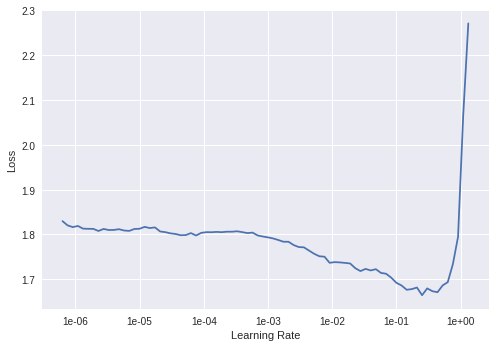

In [122]:
learn.recorder.plot()

In [123]:
learn.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,accuracy
1,1.380363,1.292236,0.477064
2,1.469988,1.480578,0.506422
3,1.367110,1.150852,0.561468
4,1.327697,1.041770,0.600000
5,1.274329,0.966825,0.666055


In [0]:
learn.save('rnn-n-stage-1')

In [0]:
learn.load('rnn-n-stage-1')

In [130]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy
1,1.176645,0.784714,0.721101
2,1.002043,0.595643,0.812844
3,0.895886,0.534713,0.814679
4,0.804908,0.470355,0.860550
5,0.795396,0.472882,0.840367


In [0]:
learn.save('rnn-n-stage-2')

In [0]:
learn.load('rnn-n-stage-2')

In [135]:
learn.freeze_to(-3)
learn.fit_one_cycle(5, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy
1,0.758974,0.426934,0.847706
2,0.620382,0.306803,0.900917
3,0.525905,0.232783,0.915596
4,0.479266,0.197147,0.928440
5,0.455785,0.179516,0.930275


In [0]:
learn.save('rnn-n-stage-3')

In [0]:
learn.load('rnn-n-stage-3')

In [138]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


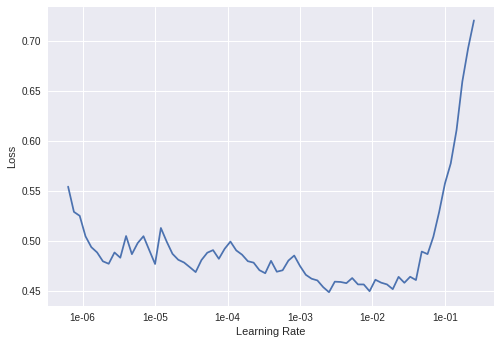

In [140]:
learn.recorder.plot(skip_end=10)

In [141]:
learn.fit_one_cycle(7, slice(8e-3/(2.6**4), 8e-3))

epoch,train_loss,valid_loss,accuracy
1,0.486961,0.176019,0.919266
2,0.433286,0.135731,0.957798
3,0.364408,0.135100,0.952294
4,0.343463,0.087165,0.970642
5,0.268003,0.074595,0.970642
6,0.283127,0.067205,0.977982
7,0.246461,0.064413,0.977982


In [0]:
learn.save('rnn-n-stage-4')

In [0]:
learn.load('rnn-n-stage-4')

### With pretrained model and no pretrained word embeddings

In [0]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1)

In [151]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


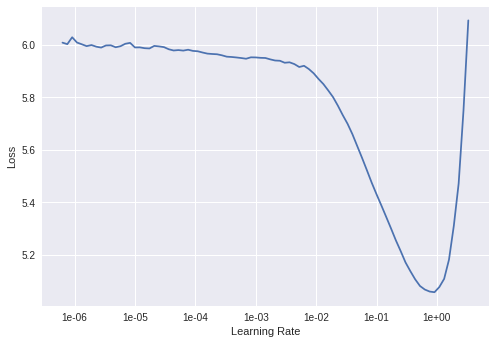

In [152]:
learn.recorder.plot()

In [153]:
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,accuracy
1,4.373490,2.774049,0.489375
2,3.497288,2.589804,0.490651
3,3.239806,2.619012,0.490367
4,3.064165,2.538915,0.499875
5,2.911237,2.521137,0.503406


In [0]:
learn.save_encoder('fine-tuned')

In [0]:
learn = text_classifier_learner(data_cl)
learn.load_encoder('fine-tuned')

In [156]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


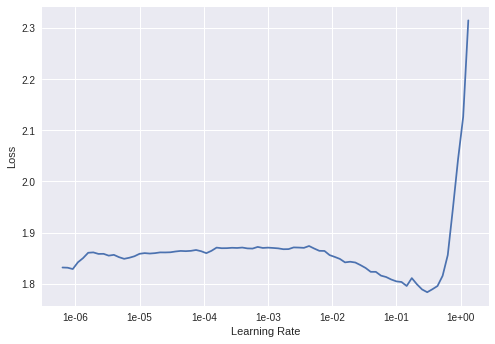

In [157]:
learn.recorder.plot()

In [158]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,1.580184,1.341189,0.453211
2,1.523417,1.131150,0.548624
3,1.462826,1.001051,0.634862
4,1.464627,1.035934,0.673395
5,1.475637,1.026982,0.649541


In [0]:
learn.save('rnn-stage-1')

In [0]:
learn.load('rnn-stage-1')

In [161]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy
1,1.409304,0.852912,0.691743
2,1.224317,0.583674,0.814679
3,1.090149,0.401397,0.840367
4,1.038827,0.308779,0.908257
5,0.950569,0.320565,0.900917


In [0]:
learn.save('rnn-stage-2')

In [0]:
learn.load('rnn-stage-2')

In [164]:
learn.freeze_to(-3)
learn.fit_one_cycle(5, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.950961,0.326079,0.891743
2,0.862750,0.295699,0.900917
3,0.773564,0.260876,0.910092
4,0.771787,0.252948,0.908257
5,0.785842,0.254357,0.910092


In [0]:
learn.save('rnn-stage-3')

In [0]:
learn.load('rnn-stage-3')

In [0]:
learn.unfreeze()

In [168]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


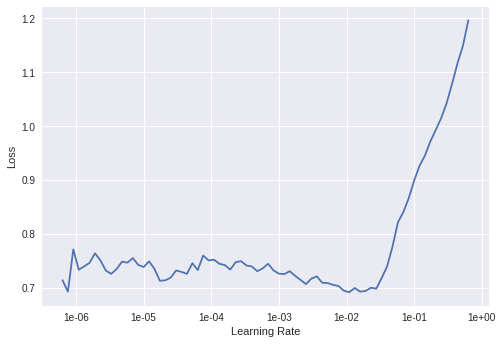

In [169]:
learn.recorder.plot()

In [170]:
learn.fit_one_cycle(7, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.634067,0.249051,0.911927
2,0.612851,0.218874,0.915596
3,0.609346,0.184819,0.930275
4,0.526805,0.180814,0.924771
5,0.476350,0.146794,0.946789
6,0.507113,0.158065,0.928440
7,0.487622,0.147750,0.943119


In [0]:
learn.save('rnn-stage-4')

In [0]:
learn.load('rnn-stage-4')